Proyek ini membangun sistem prediksi berbasis machine learning untuk membantu menganalisis kualitas tidur, durasi tidur, dan risiko gangguan tidur seseorang, menggunakan data “Sleep Health and Lifestyle”.
Sistem ini dirancang berjenjang (model chaining) agar hasil setiap model dapat memperkaya prediksi di tahap berikutnya, sehingga hasil akhir lebih akurat dan relevan.

## Import Library 

In [1]:

# Import Library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import keras_tuner as kt


## Data Understanding

Dataset yang digunakan adalah **Sleep Health and Lifestyle Dataset** yang berisi data demografi, kebiasaan, dan hasil kesehatan tidur responden. Setiap baris mewakili satu individu.

**Fitur utama:**
- Gender
- Age
- Occupation
- Sleep Duration (jam)
- Quality of Sleep (skala)
- Physical Activity Level
- Stress Level (1–10)
- BMI Category
- Heart Rate
- Daily Steps
- Sleep Disorder (target klasifikasi)

In [2]:
# Memuat Dataset
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

In [3]:
# Dimensi Dataset
print(f"Jumlah data: {df.shape[0]}")
print(f"Jumlah fitur: {df.shape[1]}")


Jumlah data: 374
Jumlah fitur: 13


In [4]:
# Menampilkan 5 baris pertama dari dataset
display(df.head())


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
# Statistik Deskriptif dari dataset
df.describe()


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [6]:
#Tipe Data
df.dtypes

Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

In [7]:
#Cek Missing Value
print(df.isnull().sum())

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


In [8]:
# Mengganti nilai missing pada kolom Sleep Disorder dengan kata 'None'
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

In [9]:
#cek data duplikat
df.duplicated().sum()

0

In [10]:
# Menampilkan jumlah nilai unik untuk setiap kolom kategorikal
for col in ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']:
    print(f"{col}:\n{df[col].value_counts()}\n")


Gender:
Gender
Male      189
Female    185
Name: count, dtype: int64

Occupation:
Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

BMI Category:
BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

Sleep Disorder:
Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64



In [11]:
# Menampilkan jumlah nilai unik untuk setiap kolom numerik
for col in ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps']:
    print(f"{col}: {df[col].nunique()} unique values")

Age: 31 unique values
Sleep Duration: 27 unique values
Quality of Sleep: 6 unique values
Physical Activity Level: 16 unique values
Stress Level: 6 unique values
BMI Category: 4 unique values
Heart Rate: 19 unique values
Daily Steps: 20 unique values


Insight Data Understanding:

- Data terdiri dari 374 baris unik, 13 kolom (demografi, gaya hidup, kesehatan, label gangguan tidur).
- Fitur numerik: 
  - Usia rata-rata 42 tahun (27–59), variasi baik.
  - Durasi tidur rata-rata 7,1 jam (5,8–8,5), mayoritas di atas 6 jam.
  - Kualitas tidur rata-rata 7,3/9, distribusi baik.
  - Aktivitas fisik rata-rata 59 (30–90), variasi cukup.
  - Stress rata-rata 5,4 (skala 3–8).
  - Heart rate rata-rata 70 bpm (65–86), langkah harian rata-rata 6.800 (3.000–10.000).
- Fitur kategorikal:
  - Gender seimbang (189 laki-laki, 185 perempuan).
  - Mayoritas profesi tenaga kesehatan (Nurse, Doctor), profesi lain minoritas.
  - BMI didominasi Normal (195) & Overweight (148), Obese sangat sedikit.
  - Sleep Disorder: Sleep Apnea 78, Insomnia 77, kelas 'None' tidak muncul di summary (perlu cek label).
- Tidak ada missing value dan duplikat, variasi fitur cukup baik.
- Dataset bersih, distribusi wajar, namun label target tidak seimbang.
- Siap lanjut ke preprocessing & feature engineering.

### Exploratory Data Analysis (EDA)

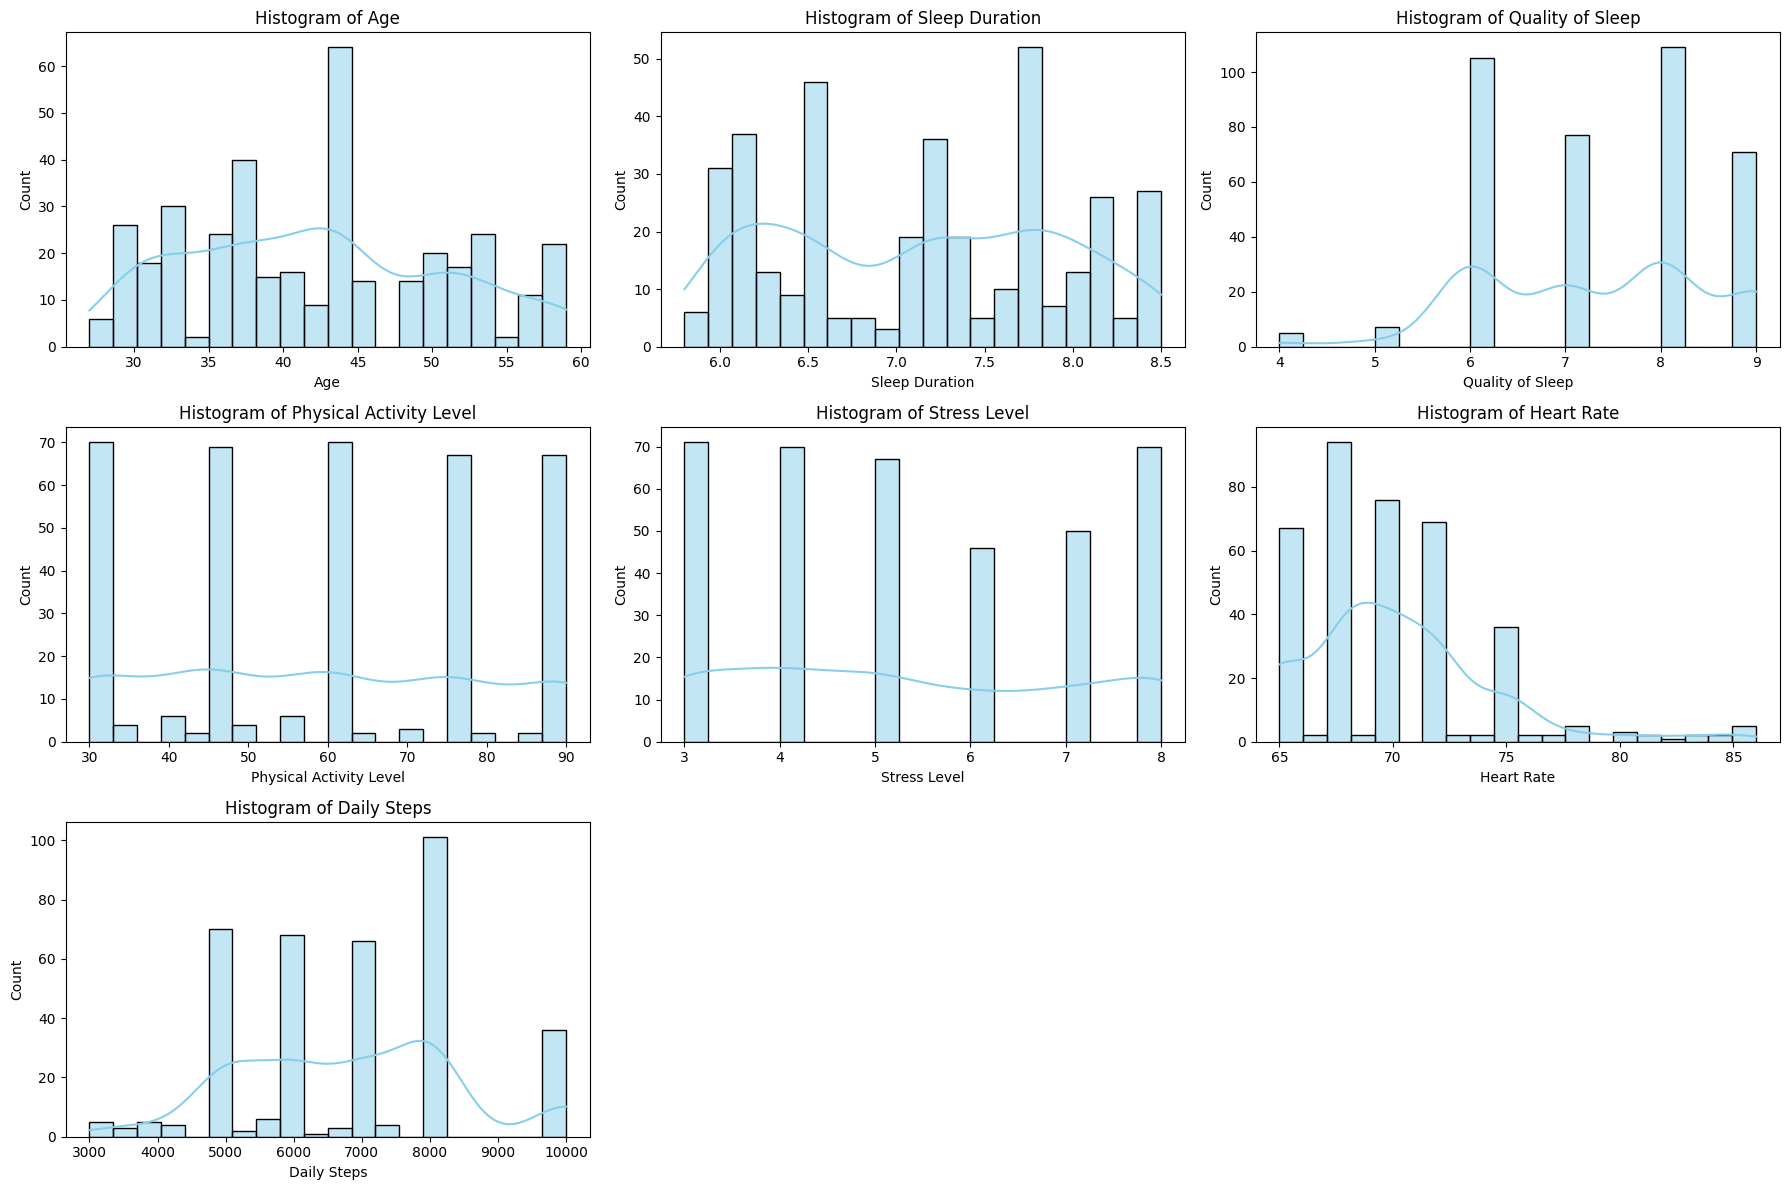

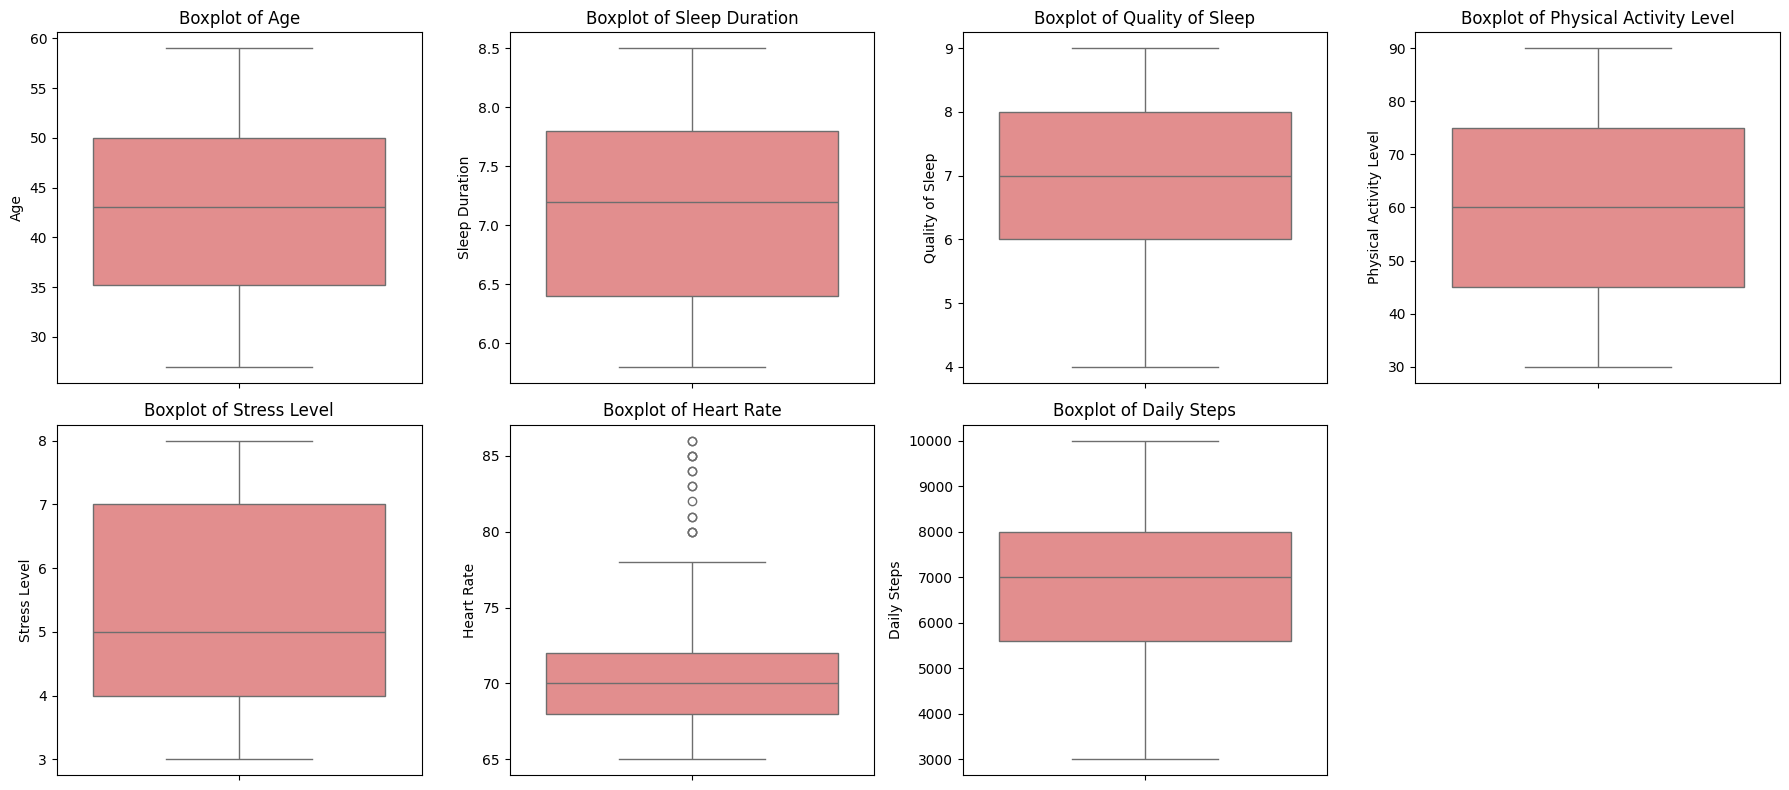

In [12]:
# Daftar fitur numerik yang akan divisualisasikan
numeric_features = [
    'Age', 'Sleep Duration', 'Quality of Sleep',
    'Physical Activity Level', 'Stress Level',
    'Heart Rate', 'Daily Steps'
]

# Histogram untuk setiap fitur numerik
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# Boxplot untuk deteksi outlier tiap fitur numerik
plt.figure(figsize=(18, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\3634150912.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)
C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\3634150912.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)
C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\3634150912.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)
C

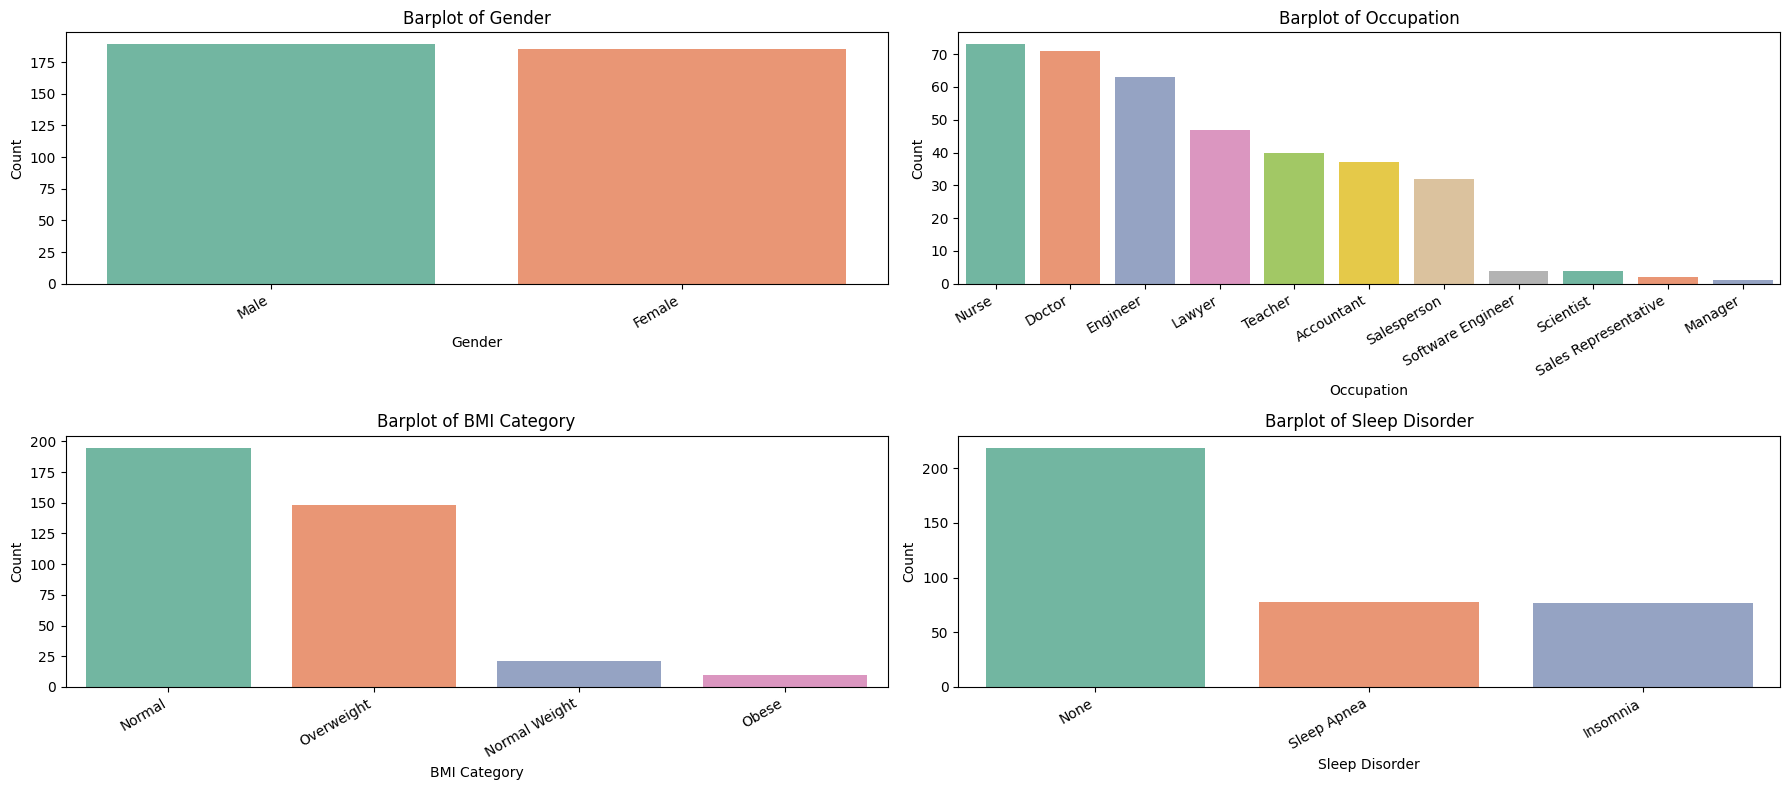

In [13]:
# Visualisasi fitur kategorikal dengan barplot

categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

plt.figure(figsize=(18, 8))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)
    plt.title(f'Barplot of {col}')
    plt.xticks(rotation=30, ha='right')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


**Cek Korelasi Antar Fitur Numerik**

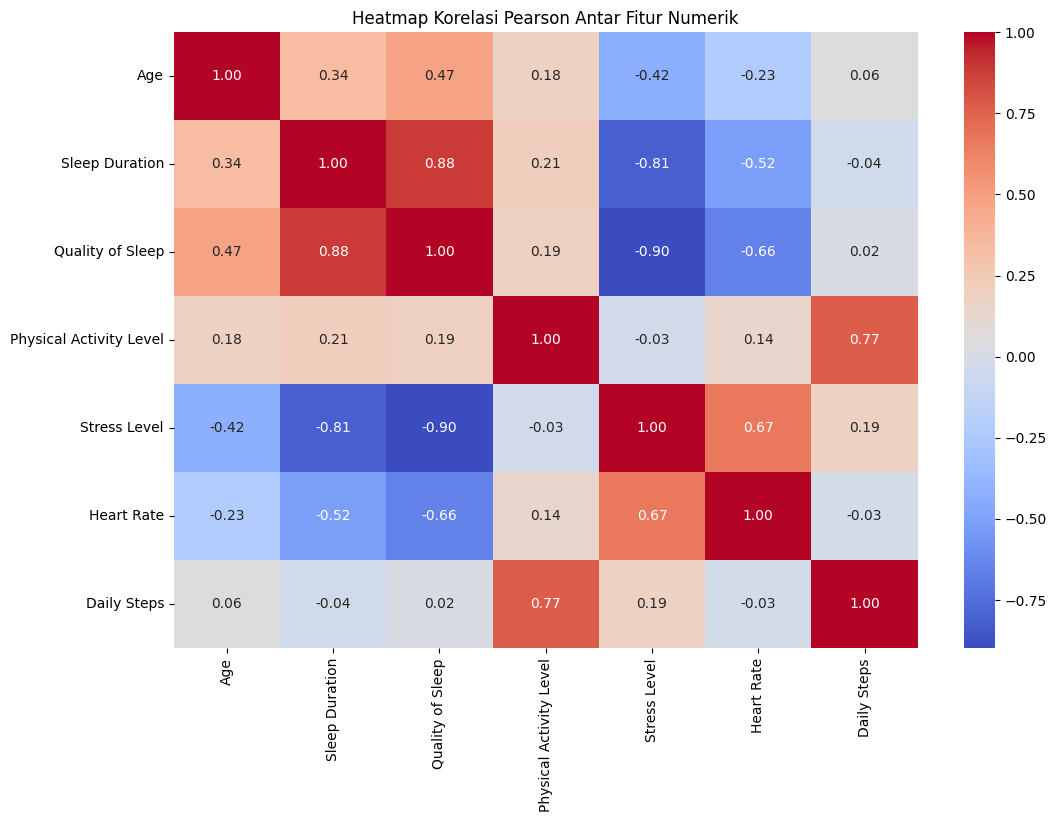

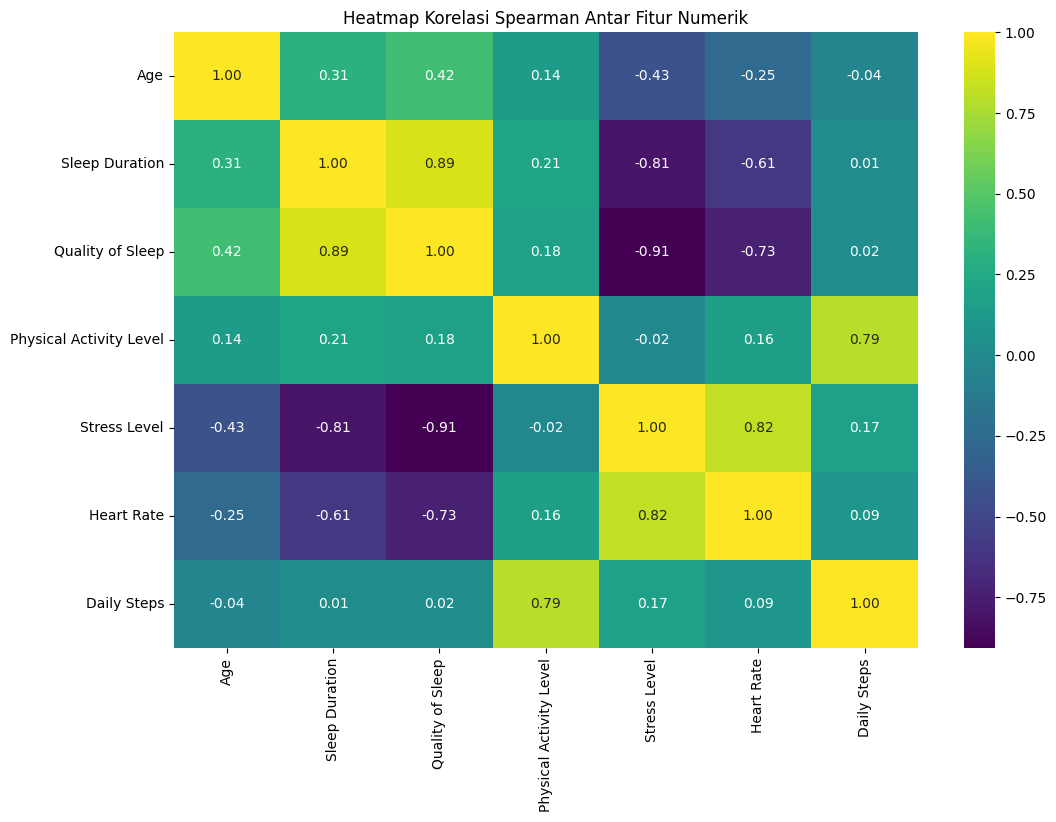


Pasangan fitur dengan korelasi tinggi atau sangat rendah (Pearson):
  Age & Physical Activity Level: 0.18 (sangat rendah)
  Age & Daily Steps: 0.06 (sangat rendah)
  Sleep Duration & Quality of Sleep: 0.88 (tinggi)
  Sleep Duration & Stress Level: -0.81 (tinggi)
  Sleep Duration & Daily Steps: -0.04 (sangat rendah)
  Quality of Sleep & Physical Activity Level: 0.19 (sangat rendah)
  Quality of Sleep & Stress Level: -0.90 (tinggi)
  Quality of Sleep & Daily Steps: 0.02 (sangat rendah)
  Physical Activity Level & Stress Level: -0.03 (sangat rendah)
  Physical Activity Level & Heart Rate: 0.14 (sangat rendah)
  Physical Activity Level & Daily Steps: 0.77 (tinggi)
  Stress Level & Daily Steps: 0.19 (sangat rendah)
  Heart Rate & Daily Steps: -0.03 (sangat rendah)

Pasangan fitur dengan korelasi tinggi atau sangat rendah (Spearman):
  Age & Physical Activity Level: 0.14 (sangat rendah)
  Age & Daily Steps: -0.04 (sangat rendah)
  Sleep Duration & Quality of Sleep: 0.89 (tinggi)
  Sleep Dur

In [14]:
# Menghitung matriks korelasi Pearson
corr_matrix_pearson = df[numeric_features].corr(method='pearson')

# Visualisasi heatmap korelasi Pearson
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Pearson Antar Fitur Numerik')
plt.show()

# Menghitung matriks korelasi Spearman
corr_matrix_spearman = df[numeric_features].corr(method='spearman')

# Visualisasi heatmap korelasi Spearman
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap Korelasi Spearman Antar Fitur Numerik')
plt.show()

# Mencatat fitur yang saling berkorelasi tinggi atau sangat rendah
# Threshold korelasi tinggi: > 0.7 atau < -0.7
high_corr_pairs = []
low_corr_pairs = []
for method, corr_matrix in [('Pearson', corr_matrix_pearson), ('Spearman', corr_matrix_spearman)]:
    print(f"\nPasangan fitur dengan korelasi tinggi atau sangat rendah ({method}):")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                print(f"  {corr_matrix.columns[i]} & {corr_matrix.columns[j]}: {corr_value:.2f} (tinggi)")
            elif abs(corr_value) < 0.2:
                print(f"  {corr_matrix.columns[i]} & {corr_matrix.columns[j]}: {corr_value:.2f} (sangat rendah)")

**Analisis Imbalance pada Target (Sleep Disorder)**

Jumlah tiap kelas Sleep Disorder (None, Sleep Apnea, Insomnia):
Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

Proporsi tiap kelas Sleep Disorder (None, Sleep Apnea, Insomnia):
Sleep Disorder
None           0.585561
Sleep Apnea    0.208556
Insomnia       0.205882
Name: proportion, dtype: float64


C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\142366816.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disorder_counts.index, y=disorder_counts.values, palette='Set2')


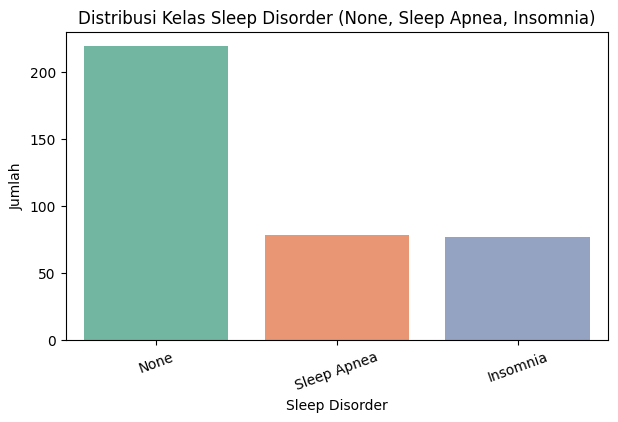

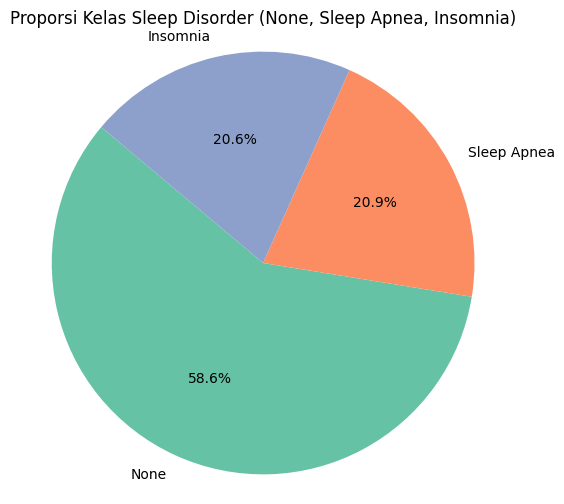


Tidak ada kelas minoritas yang proporsinya < 10% pada Sleep Disorder (None, Sleep Apnea, Insomnia).


In [15]:
# Hitung jumlah dan proporsi setiap kelas pada Sleep Disorder
disorder_counts = df['Sleep Disorder'].value_counts()
disorder_props = df['Sleep Disorder'].value_counts(normalize=True)

print("Jumlah tiap kelas Sleep Disorder (None, Sleep Apnea, Insomnia):")
print(disorder_counts)
print("\nProporsi tiap kelas Sleep Disorder (None, Sleep Apnea, Insomnia):")
print(disorder_props)

# Visualisasi: Barplot proporsi kelas
plt.figure(figsize=(7,4))
sns.barplot(x=disorder_counts.index, y=disorder_counts.values, palette='Set2')
plt.title('Distribusi Kelas Sleep Disorder (None, Sleep Apnea, Insomnia)')
plt.ylabel('Jumlah')
plt.xlabel('Sleep Disorder')
plt.xticks(rotation=20)
plt.show()

# Visualisasi: Pie chart proporsi kelas
plt.figure(figsize=(6,6))
plt.pie(disorder_counts, labels=disorder_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Proporsi Kelas Sleep Disorder (None, Sleep Apnea, Insomnia)')
plt.axis('equal')
plt.show()

# Highlight kelas minoritas
threshold_minoritas = 0.10  # misal, kelas dengan proporsi <10% dianggap minoritas
minority_classes = disorder_props[disorder_props < threshold_minoritas]

if not minority_classes.empty:
    print("\nPERINGATAN: Ditemukan kelas minoritas pada Sleep Disorder (proporsi < 10%):")
    for cls, prop in minority_classes.items():
        print(f"  - {cls}: {prop*100:.2f}% ({disorder_counts[cls]} data)")
else:
    print("\nTidak ada kelas minoritas yang proporsinya < 10% pada Sleep Disorder (None, Sleep Apnea, Insomnia).")

**Analisis Hubungan Fitur ke Target**

C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\243413269.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep Disorder', y='Sleep Duration', data=df, palette='Set2')


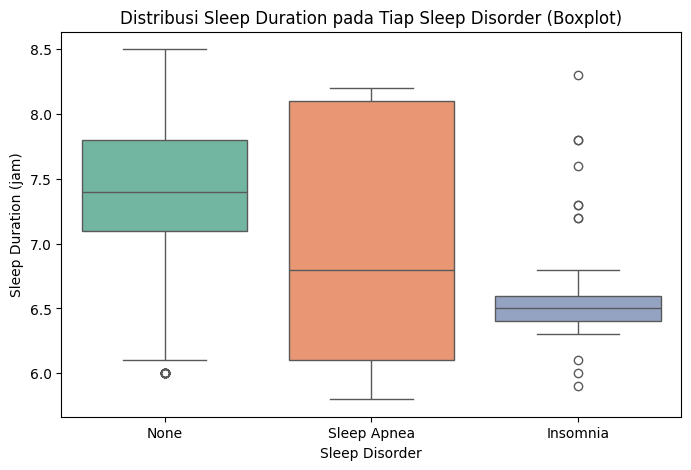

C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\243413269.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sleep Disorder', y='Quality of Sleep', data=df, palette='Set2')


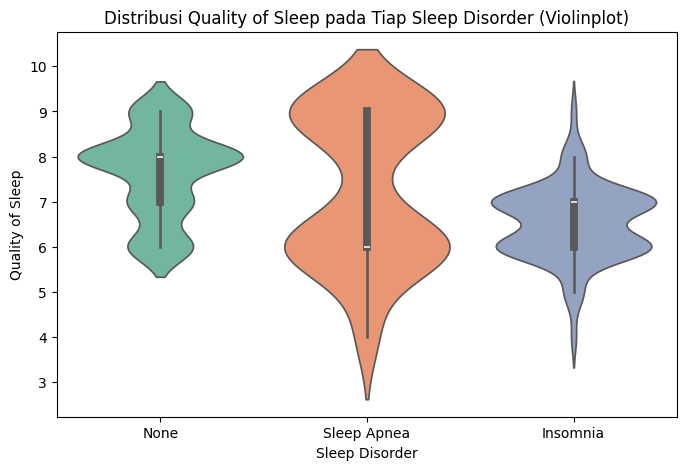

C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\243413269.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_quality_occupation.index, y=mean_quality_occupation.values, palette='Set2')


Rata-rata Quality of Sleep per Occupation:
Occupation
Engineer                8.412698
Lawyer                  7.893617
Accountant              7.891892
Nurse                   7.369863
Manager                 7.000000
Teacher                 6.975000
Doctor                  6.647887
Software Engineer       6.500000
Salesperson             6.000000
Scientist               5.000000
Sales Representative    4.000000
Name: Quality of Sleep, dtype: float64


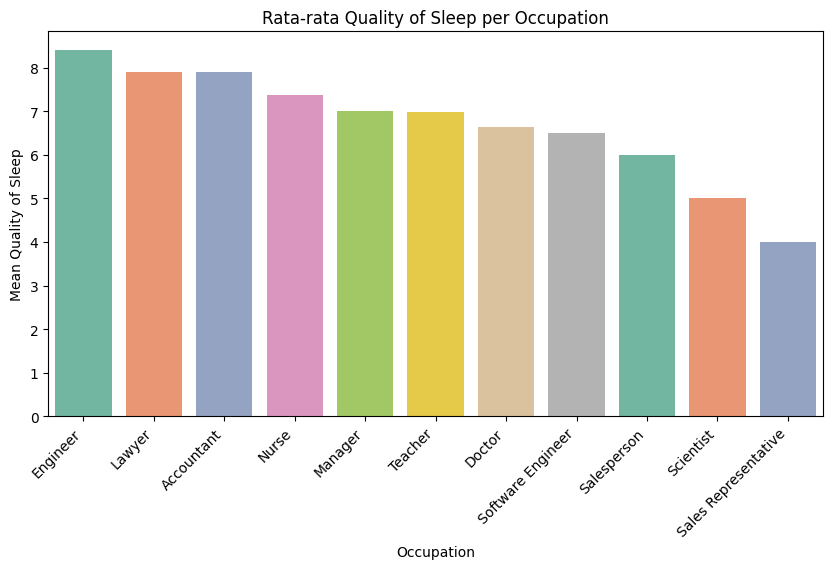


Rata-rata Quality of Sleep per Gender:
Gender
Female    7.664865
Male      6.968254
Name: Quality of Sleep, dtype: float64


C:\Users\ardhi\AppData\Local\Temp\ipykernel_7900\243413269.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_quality_gender.index, y=mean_quality_gender.values, palette='Set2')


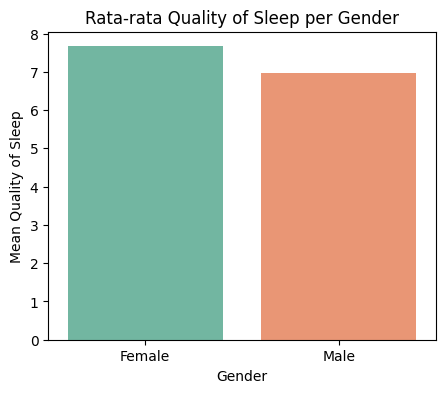

In [16]:
# Visualisasi distribusi fitur numerik berdasarkan kelas target Sleep Disorder
# Boxplot untuk melihat distribusi Sleep Duration pada tiap kelas Sleep Disorder
plt.figure(figsize=(8,5))
sns.boxplot(x='Sleep Disorder', y='Sleep Duration', data=df, palette='Set2')
plt.title('Distribusi Sleep Duration pada Tiap Sleep Disorder (Boxplot)')
plt.xlabel('Sleep Disorder')
plt.ylabel('Sleep Duration (jam)')
plt.show()

# Violinplot untuk melihat distribusi Quality of Sleep pada tiap kelas Sleep Disorder
plt.figure(figsize=(8,5))
sns.violinplot(x='Sleep Disorder', y='Quality of Sleep', data=df, palette='Set2')
plt.title('Distribusi Quality of Sleep pada Tiap Sleep Disorder (Violinplot)')
plt.xlabel('Sleep Disorder')
plt.ylabel('Quality of Sleep')
plt.show()

# Analisis rata-rata Quality of Sleep berdasarkan Occupation
mean_quality_occupation = df.groupby('Occupation')['Quality of Sleep'].mean().sort_values(ascending=False)
print("Rata-rata Quality of Sleep per Occupation:")
print(mean_quality_occupation)

# Visualisasi rata-rata Quality of Sleep per Occupation
plt.figure(figsize=(10,5))
sns.barplot(x=mean_quality_occupation.index, y=mean_quality_occupation.values, palette='Set2')
plt.title('Rata-rata Quality of Sleep per Occupation')
plt.xlabel('Occupation')
plt.ylabel('Mean Quality of Sleep')
plt.xticks(rotation=45, ha='right')
plt.show()

# Analisis rata-rata Quality of Sleep berdasarkan Gender
mean_quality_gender = df.groupby('Gender')['Quality of Sleep'].mean()
print("\nRata-rata Quality of Sleep per Gender:")
print(mean_quality_gender)

# Visualisasi rata-rata Quality of Sleep per Gender
plt.figure(figsize=(5,4))
sns.barplot(x=mean_quality_gender.index, y=mean_quality_gender.values, palette='Set2')
plt.title('Rata-rata Quality of Sleep per Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Quality of Sleep')
plt.show()


Insight EDA utama:

1. Fitur Numerik:
- Usia peserta 27–59 tahun, rata-rata 42 tahun.
- Durasi tidur rata-rata 7,1 jam, mayoritas 6,4–7,8 jam.
- Kualitas tidur rata-rata 7,3 (skala 4–9), umumnya menengah-tinggi.
- Aktivitas fisik rata-rata 59 (rentang 30–90), gaya hidup beragam.
- Stres rata-rata 5,4 (skala 3–8), banyak di tingkat menengah.
- Detak jantung rata-rata 70 bpm, ada outlier >80.
- Langkah harian umumnya 5.000–8.000, sedikit outlier >10.000.

2. Fitur Kategorik:
- Gender hampir seimbang (pria 189, wanita 185).
- Profesi didominasi perawat, dokter, insinyur; profesi minoritas sangat sedikit.
- BMI mayoritas "Normal" (195) dan "Overweight" (148).
- Gangguan tidur: mayoritas "None" (58%), sisanya "Sleep Apnea" & "Insomnia" seimbang (~21%).

3. Korelasi Fitur:
- Korelasi sangat kuat: Durasi tidur & kualitas tidur (positif), aktivitas fisik & langkah harian (positif), kualitas tidur & stres (negatif), durasi tidur & stres (negatif), stres & detak jantung (positif).
- Korelasi sangat rendah: Banyak pasangan fitur, misal usia vs langkah, kualitas tidur vs langkah.

4. Outlier & Distribusi:
- Outlier jelas di detak jantung (>80) dan langkah harian (>10.000).
- Distribusi numerik umumnya simetris, beberapa sedikit skew ke kanan.

5. Proporsi Kelas:
- Gangguan tidur: "None" dominan, "Sleep Apnea" & "Insomnia" seimbang.
- Rata-rata kualitas tidur tertinggi pada engineer, terendah sales rep & scientist.
- Wanita rata-rata kualitas tidur lebih baik dari pria.

6. Kesimpulan:
- Kualitas tidur sangat dipengaruhi durasi tidur & stres.
- Aktivitas fisik saling berhubungan, tapi tidak terlalu terkait kualitas tidur.
- Imbalance pada kelas gangguan tidur perlu diperhatikan.
- Outlier & distribusi profesi minoritas bisa memicu bias prediksi.

## Data Preprocessing

Karena menggunakan model chaining, maka untuk tahapan data preprocessing, modeling, dan evaluation dilakukan secara berurutan (tidak dijadikan dalam satu tahapan). Berikut adalah pipelinenya:

➔ Langkah 1: Prediksi Kualitas Tidur (Quality of Sleep)
   - Input  : Data fitur demografis dan aktivitas, yaitu:
       • Gender
       • Usia
       • Pekerjaan
       • Aktivitas fisik
       • Level stres
       • BMI
       • Detak jantung
       • Langkah harian
   - Output : Prediksi numerik kualitas tidur
   - Model  : Neural Network (regresi)

➔ Langkah 2: Prediksi Durasi Tidur (Sleep Duration)
   - Input  : Semua fitur asli
              + hasil prediksi kualitas tidur dari Langkah 1
   - Output : Prediksi durasi tidur (dalam jam)
   - Model  : Neural Network (regresi)

➔ Langkah 3: Klasifikasi Gangguan Tidur (Sleep Disorder)
   - Input  : Semua fitur asli
              + prediksi kualitas tidur (Langkah 1)
              + prediksi durasi tidur (Langkah 2)
   - Output : Kategori gangguan tidur (“None”, “Insomnia”, “Sleep Apnea”)
   - Model  : Neural Network (klasifikasi)


Urutan Kerja Pipeline:

1. Lakukan preprocessing data untuk langkah 1, kemudian latih dan evaluasi Model 1, lalu tambahkan hasil prediksi ke data.
2. Lakukan preprocessing data untuk langkah 2 (dengan fitur baru dari prediksi 1), kemudian latih dan evaluasi Model 2, lalu tambahkan hasil prediksi ke data.
3. Lakukan preprocessing data untuk langkah 3 (dengan fitur baru dari prediksi 2), kemudian latih dan evaluasi Model 3.

#### Data Prepocessing Awal

In [17]:
# Cek outlier pada fitur numerik menggunakan metode IQR
outlier_summary = {}

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    outlier_summary[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': outlier_count
    }
    print(f"Fitur: {col}")
    print(f"  Jumlah outlier: {outlier_count}")
    print(f"  Batas bawah: {lower_bound:.2f}, Batas atas: {upper_bound:.2f}")
    print("-" * 40)




Fitur: Age
  Jumlah outlier: 0
  Batas bawah: 13.12, Batas atas: 72.12
----------------------------------------
Fitur: Sleep Duration
  Jumlah outlier: 0
  Batas bawah: 4.30, Batas atas: 9.90
----------------------------------------
Fitur: Quality of Sleep
  Jumlah outlier: 0
  Batas bawah: 3.00, Batas atas: 11.00
----------------------------------------
Fitur: Physical Activity Level
  Jumlah outlier: 0
  Batas bawah: 0.00, Batas atas: 120.00
----------------------------------------
Fitur: Stress Level
  Jumlah outlier: 0
  Batas bawah: -0.50, Batas atas: 11.50
----------------------------------------
Fitur: Heart Rate
  Jumlah outlier: 15
  Batas bawah: 62.00, Batas atas: 78.00
----------------------------------------
Fitur: Daily Steps
  Jumlah outlier: 0
  Batas bawah: 2000.00, Batas atas: 11600.00
----------------------------------------


In [18]:
# Atasi outlier dengan Clipping pada fitur numerik
df['Daily Steps'] = df['Daily Steps'].clip(lower=2000, upper=11600)
df['Heart Rate'] = df['Heart Rate'].clip(lower=62, upper=80)


In [19]:
# Gabungkan kelas Occupation yang jumlahnya sedikit ke dalam kategori 'others'
min_count = 10
vc = df['Occupation'].value_counts()
minority_cats = vc[vc < min_count].index
df['Occupation_cleaned'] = df['Occupation'].apply(lambda x: x if x not in minority_cats else 'Others')

print(df['Occupation_cleaned'].value_counts())


Occupation_cleaned
Nurse          73
Doctor         71
Engineer       63
Lawyer         47
Teacher        40
Accountant     37
Salesperson    32
Others         11
Name: count, dtype: int64


In [20]:

# Label encoding untuk fitur kategorik: Gender, Occupation, BMI Category, dan Sleep Disorder
le_gender = LabelEncoder()
le_occupation = LabelEncoder()
le_bmi = LabelEncoder()
le_disorder = LabelEncoder()

# Transformasi label menjadi kode numerik dan simpan ke kolom baru
df['Gender_cod'] = le_gender.fit_transform(df['Gender'])
df['Occupation_cod'] = le_occupation.fit_transform(df['Occupation_cleaned'])
df['BMI Category_cod'] = le_bmi.fit_transform(df['BMI Category'])
df['Sleep Disorder_cod'] = le_disorder.fit_transform(df['Sleep Disorder'])

# Simpan encoder ke file agar bisa digunakan saat prediksi data baru
joblib.dump(le_gender, 'encoder_gender.joblib')
joblib.dump(le_occupation, 'encoder_occupation.joblib')
joblib.dump(le_bmi, 'encoder_bmi.joblib')
joblib.dump(le_disorder, 'encoder_disorder.joblib')


['encoder_disorder.joblib']

**Model 1: Regresi Quality of Sleep**

**DATA PREPROCESSING MODEL 1**

In [21]:
# Daftar fitur yang digunakan untuk prediksi Quality of Sleep
features_quality = [
    'Gender_cod', 'Age', 'Occupation_cod',
    'Physical Activity Level', 'Stress Level',
    'BMI Category_cod', 'Heart Rate', 'Daily Steps'
]

# Target yang akan diprediksi
target_quality = 'Quality of Sleep'

# Membagi data menjadi fitur (X) dan target (y)
X_q = df[features_quality]
y_q = df[target_quality]

# Split data menjadi data latih dan data uji (80:20)
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_q, y_q, test_size=0.2, random_state=42)

# Standarisasi fitur numerik agar model lebih stabil
scaler_quality = StandardScaler()
X_train_q_scaled = scaler_quality.fit_transform(X_train_q)
X_test_q_scaled = scaler_quality.transform(X_test_q)

# Simpan scaler agar bisa digunakan saat prediksi data baru
joblib.dump(scaler_quality, 'scaler_quality.joblib')

['scaler_quality.joblib']

**TUNING HYPERPARAMETER**

In [22]:
# Fungsi untuk membangun model neural network dengan hyperparameter yang dapat di-tuning
def build_model_quality(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_q_scaled.shape[1],)))
    # Layer dense pertama dengan jumlah unit dan aktivasi yang di-tuning
    model.add(layers.Dense(hp.Int('units1', 64, 256, step=32), activation=hp.Choice('act1', ['relu', 'tanh'])))
    model.add(layers.BatchNormalization())
    # Dropout pertama dengan rate yang di-tuning
    model.add(layers.Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    # Layer dense kedua dengan jumlah unit dan aktivasi yang di-tuning
    model.add(layers.Dense(hp.Int('units2', 32, 128, step=16), activation=hp.Choice('act2', ['relu', 'tanh'])))
    model.add(layers.BatchNormalization())
    # Dropout kedua dengan rate yang di-tuning
    model.add(layers.Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    # Layer dense ketiga dengan jumlah unit dan aktivasi yang di-tuning
    model.add(layers.Dense(hp.Int('units3', 16, 64, step=16), activation=hp.Choice('act3', ['relu', 'tanh'])))
    model.add(layers.BatchNormalization())
    # Output layer (regresi, 1 neuron)
    model.add(layers.Dense(1))
    # Kompilasi model dengan optimizer dan learning rate yang di-tuning
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Inisialisasi objek tuner untuk melakukan pencarian hyperparameter terbaik
tuner = kt.RandomSearch(
    build_model_quality,
    objective='val_loss',
    max_trials=20,
    directory='tuner_dir_quality',
    project_name='qos'
)

tuner.search(
X_train_q_scaled, y_train_q,
    epochs=30,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Reloading Tuner from tuner_dir_quality\qos\tuner0.json


**MODELING MODEL 1**

In [23]:

# Mendapatkan best_hp dari hasil tuning hyperparameter
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# === BLOK MODELING (TRAINING) ===
model_quality = build_model_quality(best_hp)
history_q = model_quality.fit(
    X_train_q_scaled, y_train_q, 
    epochs=100, batch_size=16, 
    validation_split=0.2, verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
    ]
)
model_quality.save('model_quality.keras')


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 51.5630 - mae: 7.0730 - val_loss: 43.1385 - val_mae: 6.5527 - learning_rate: 0.0100
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 35.6053 - mae: 5.9178 - val_loss: 25.4327 - val_mae: 5.0229 - learning_rate: 0.0100
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.8077 - mae: 3.9723 - val_loss: 4.5866 - val_mae: 2.0559 - learning_rate: 0.0100
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4157 - mae: 1.3746 - val_loss: 0.4749 - val_mae: 0.5726 - learning_rate: 0.0100
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6645 - mae: 0.6658 - val_loss: 0.3272 - val_mae: 0.4478 - learning_rate: 0.0100
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3430 - mae: 0.4519 - val_loss: 0.2583 - val_mae: 0.4064 - learning_rate: 0.0100
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2204 - mae: 0.3438 - val_loss: 0.1317 - val_mae: 0.2746 - learning_rate: 0.0100
E

**EVALUATION MODEL 1**

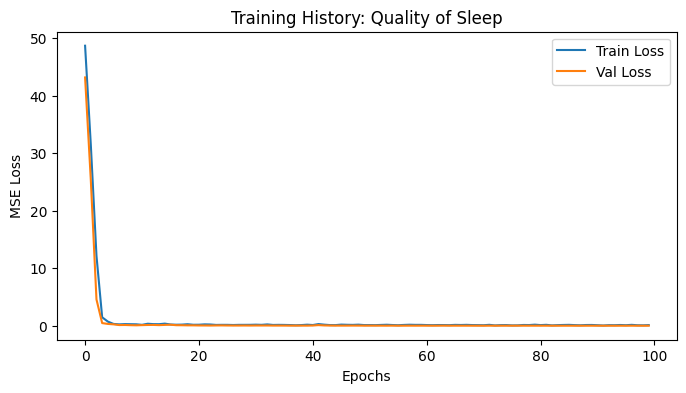

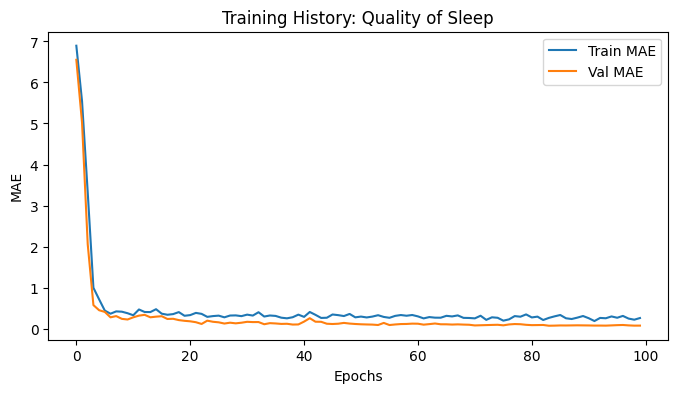

In [24]:
# plot history training dan validasi loss (MSE) untuk Quality of Sleep
plt.figure(figsize=(8,4))
plt.plot(history_q.history['loss'], label='Train Loss')   
plt.plot(history_q.history['val_loss'], label='Val Loss')  
plt.title('Training History: Quality of Sleep')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Plot history training dan validasi MAE untuk Quality of Sleep 
plt.figure(figsize=(8,4))
plt.plot(history_q.history['mae'], label='Train MAE')
plt.plot(history_q.history['val_mae'], label='Val MAE')
plt.title('Training History: Quality of Sleep')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Evaluasi Regresi Quality of Sleep
R2: 0.9883
MAE: 0.0677
MSE: 0.0176



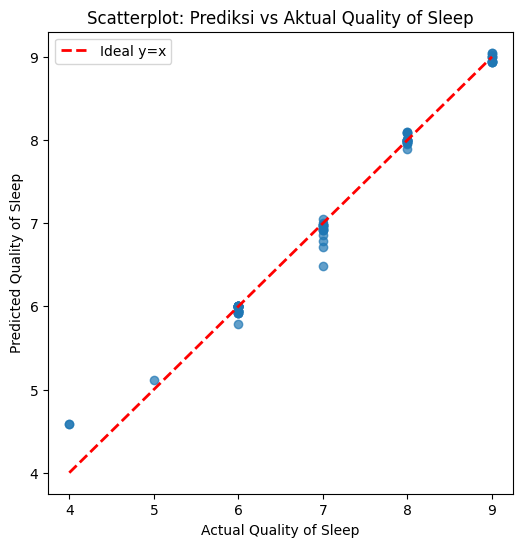

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [25]:
# Evaluasi Model Quality of Sleep pada data test
y_pred_q = model_quality.predict(X_test_q_scaled).flatten()
print('Evaluasi Regresi Quality of Sleep')
print(f'R2: {r2_score(y_test_q, y_pred_q):.4f}')
print(f'MAE: {mean_absolute_error(y_test_q, y_pred_q):.4f}')
print(f'MSE: {mean_squared_error(y_test_q, y_pred_q):.4f}\n')

# Scatterplot: membandingkan prediksi vs aktual pada Quality of Sleep
plt.figure(figsize=(6,6))
plt.scatter(y_test_q, y_pred_q, alpha=0.7)
plt.plot([y_test_q.min(), y_test_q.max()], [y_test_q.min(), y_test_q.max()], 
         'r--', lw=2, label="Ideal y=x")
plt.xlabel("Actual Quality of Sleep")
plt.ylabel("Predicted Quality of Sleep")
plt.title("Scatterplot: Prediksi vs Aktual Quality of Sleep")
plt.legend()
plt.show()

# Simpan hasil prediksi Quality of Sleep ke dataframe utama
df['Pred_Quality'] = model_quality.predict(scaler_quality.transform(X_q)).flatten()

**Model 2: Regresi Sleep Duration**

**DATA PREPROCESSING MODEL 2**

In [26]:
# Pilih fitur untuk prediksi Sleep Duration, termasuk Pred_Quality dari model sebelumnya
features_duration = features_quality + ['Pred_Quality']
target_duration = 'Sleep Duration'

# Split data menjadi fitur (X) dan target (y)
X_d = df[features_duration]
y_d = df[target_duration]

# Bagi data menjadi data latih dan data uji
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

# Standarisasi fitur
scaler_duration = StandardScaler()
X_train_d_scaled = scaler_duration.fit_transform(X_train_d)
X_test_d_scaled = scaler_duration.transform(X_test_d)

# Simpan scaler untuk digunakan pada data baru
joblib.dump(scaler_duration, 'scaler_duration.joblib')


['scaler_duration.joblib']

**TUNING HYPERPARAMETER**

In [27]:
# Fungsi untuk membangun model regresi Sleep Duration dengan hyperparameter tuning
def build_model_duration(hp):
    # Membuat model Sequential
    model = keras.Sequential()
    # Input layer dengan jumlah fitur sesuai data yang sudah diskalakan
    model.add(layers.Input(shape=(X_train_d_scaled.shape[1],)))
    # Hidden layer pertama dengan jumlah unit dan aktivasi yang ditentukan oleh hyperparameter
    model.add(layers.Dense(
        hp.Int('units1', 64, 256, step=32), 
        activation=hp.Choice('act1', ['relu', 'tanh'])
    ))
    # Batch Normalization setelah hidden layer pertama
    model.add(layers.BatchNormalization())
    # Hidden layer kedua dengan jumlah unit dan aktivasi yang juga ditentukan oleh hyperparameter
    model.add(layers.Dense(
        hp.Int('units2', 32, 128, step=16), 
        activation=hp.Choice('act2', ['relu', 'tanh'])
    ))
    # Batch Normalization setelah hidden layer kedua
    model.add(layers.BatchNormalization())
    # Output layer (regresi, 1 neuron)
    model.add(layers.Dense(1))
    # Kompilasi model dengan optimizer Adam dan learning rate yang ditentukan oleh hyperparameter
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

import keras_tuner as kt

# Inisialisasi RandomSearch untuk tuning hyperparameter model durasi tidur
tuner_duration = kt.RandomSearch(
    build_model_duration,
    objective='val_loss', # Tujuan tuning adalah meminimalkan validation loss
    max_trials=10, # Jumlah percobaan kombinasi hyperparameter
    directory='tuner_dir_duration', # Direktori untuk menyimpan hasil tuning
    project_name='duration' # Nama proyek tuning
)

# Proses pencarian hyperparameter terbaik dengan data training
tuner_duration.search(
    X_train_d_scaled, y_train_d, 
    epochs=30, 
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Mengambil hyperparameter terbaik hasil tuning
best_hp_duration = tuner_duration.get_best_hyperparameters()[0]

Reloading Tuner from tuner_dir_duration\duration\tuner0.json


**MODELING MODEL 2**

In [28]:
# Training model regresi Sleep Duration dengan hyperparameter terbaik
model_duration = build_model_duration(best_hp_duration)
history_d = model_duration.fit(
    X_train_d_scaled, y_train_d, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
)

# Simpan model yang sudah dilatih
model_duration.save('model_duration.keras')

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 48.0151 - mae: 6.7628 - val_loss: 24.1848 - val_mae: 4.8804 - learning_rate: 0.0100
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19.2274 - mae: 4.1874 - val_loss: 0.3167 - val_mae: 0.4601 - learning_rate: 0.0100
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3859 - mae: 0.9901 - val_loss: 2.1873 - val_mae: 1.3442 - learning_rate: 0.0100
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0171 - mae: 0.8022 - val_loss: 0.6645 - val_mae: 0.6246 - learning_rate: 0.0100
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5834 - mae: 0.6035 - val_loss: 0.2373 - val_mae: 0.4298 - learning_rate: 0.0100
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2152 - mae: 0.3682 - val_loss: 0.1542 - val_mae: 0.3475 - learning_rate: 0.0100
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2233 - mae: 0.3898 - val_loss: 0.1313 - val_mae: 0.3037 - learning_rate: 0.0100
Epo

**EVALUATION MODEL 2**

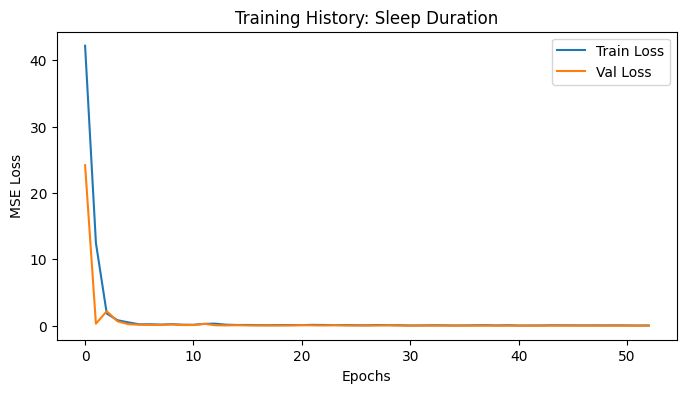

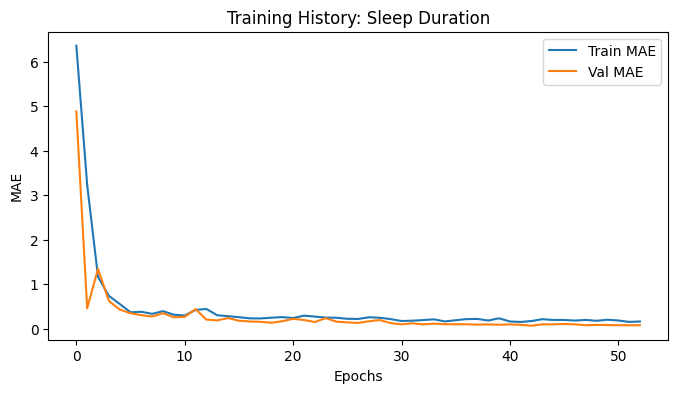

In [29]:
# Plot history loss dan val_loss selama training model regresi Sleep Duration
plt.figure(figsize=(8,4))
plt.plot(history_d.history['loss'], label='Train Loss')
plt.plot(history_d.history['val_loss'], label='Val Loss')
plt.title('Training History: Sleep Duration')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Plot history MAE (Mean Absolute Error) pada data training dan validasi
plt.figure(figsize=(8,4))
plt.plot(history_d.history['mae'], label='Train MAE')
plt.plot(history_d.history['val_mae'], label='Val MAE')
plt.title('Training History: Sleep Duration')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Evaluasi Regresi Sleep Duration
R2: 0.9668
MAE: 0.0895
MSE: 0.0221



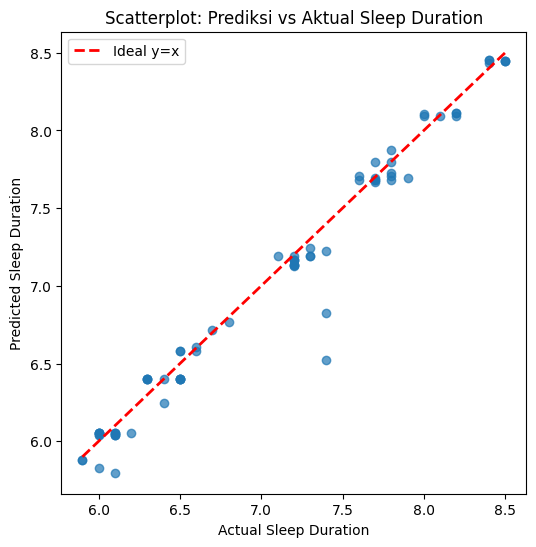

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [30]:

# Evaluasi model regresi Sleep Duration pada data test
y_pred_d = model_duration.predict(X_test_d_scaled).flatten()
print('Evaluasi Regresi Sleep Duration')
print(f'R2: {r2_score(y_test_d, y_pred_d):.4f}')
print(f'MAE: {mean_absolute_error(y_test_d, y_pred_d):.4f}')
print(f'MSE: {mean_squared_error(y_test_d, y_pred_d):.4f}\n')

# Visualisasi scatterplot antara nilai aktual dan prediksi Sleep Duration
plt.figure(figsize=(6,6))
plt.scatter(y_test_d, y_pred_d, alpha=0.7)
plt.plot([y_test_d.min(), y_test_d.max()], [y_test_d.min(), y_test_d.max()], 'r--', lw=2, label="Ideal y=x")
plt.xlabel("Actual Sleep Duration")
plt.ylabel("Predicted Sleep Duration")
plt.title("Scatterplot: Prediksi vs Aktual Sleep Duration")
plt.legend()
plt.show()

# Simpan hasil prediksi Sleep Duration ke dalam kolom baru pada dataframe
df['Pred_Duration'] = model_duration.predict(scaler_duration.transform(X_d)).flatten()

**Model 3: Klasifikasi Sleep Disorder**

**PREPROCESSING DATA MODEL 3**

In [31]:
# Membuat daftar fitur untuk model Sleep Disorder
features_duration = features_quality + ['Pred_Quality']  # Fitur untuk prediksi durasi tidur
features_disorder = features_duration + ['Pred_Duration']  # Fitur untuk prediksi sleep disorder
target_disorder = 'Sleep Disorder_cod'  # Target variabel sleep disorder (sudah di-encode)

# Membagi data menjadi fitur (X) dan target (y) untuk sleep disorder
X_c = df[features_disorder]
y_c = df[target_disorder]

# Split data menjadi data train dan test untuk sleep disorder
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)

# Standarisasi fitur (meskipun model tree tidak wajib, dilakukan agar pipeline konsisten)
scaler_disorder = StandardScaler()
X_train_c_scaled = scaler_disorder.fit_transform(X_train_c)
X_test_c_scaled = scaler_disorder.transform(X_test_c)
joblib.dump(scaler_disorder, 'scaler_disorder.joblib')  # Simpan scaler untuk digunakan kembali

['scaler_disorder.joblib']

**MODELING MODEL 3**

In [32]:
# Hitung class_weight agar model lebih seimbang ke minoritas
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_c), y=y_train_c)
cw_dict = dict(enumerate(class_weights))

# Inisialisasi dan latih model RandomForestClassifier tanpa tuning
rf_disorder = RandomForestClassifier(class_weight=cw_dict, random_state=42)
rf_disorder.fit(X_train_c_scaled, y_train_c)


RandomForestClassifier(class_weight={0: 1.60752688172043, 1: 0.5695238095238095,
                                     2: 1.60752688172043},
                       random_state=42)

**HYPERPARAMETER TUNING**

In [33]:
# Definisikan grid parameter yang akan dicoba pada GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],         # Jumlah pohon dalam Random Forest
    'max_depth': [None, 8, 12, 16],          # Maksimum kedalaman pohon
    'min_samples_split': [2, 5, 10],         # Minimum sampel untuk split internal node
    'min_samples_leaf': [1, 2, 4]            # Minimum sampel pada daun
}

# Inisialisasi model RandomForestClassifier dengan class_weight hasil perhitungan sebelumnya
rf = RandomForestClassifier(class_weight=cw_dict, random_state=42)

# Lakukan pencarian grid (GridSearchCV) untuk mencari kombinasi parameter terbaik
grid = GridSearchCV(
    rf, 
    param_grid, 
    cv=3,                      # 3-fold cross validation
    scoring='accuracy',        # Skor evaluasi menggunakan akurasi
    n_jobs=-1,                 # Gunakan seluruh core CPU
    verbose=1                  # Tampilkan progress
)
grid.fit(X_train_c_scaled, y_train_c)        # Latih model pada data training

# Tampilkan parameter terbaik hasil tuning
print("Best Params:", grid.best_params_)

# Simpan model terbaik hasil tuning ke variabel
clf_disorder = grid.best_estimator_

# Simpan model hasil tuning ke file agar bisa digunakan pada pipeline prediksi
joblib.dump(clf_disorder, 'model_disorder.joblib')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


['model_disorder.joblib']

**EVALUATION MODEL 3**

Akurasi: 0.9066666666666666
              precision    recall  f1-score   support

    Insomnia       0.72      0.87      0.79        15
        None       1.00      0.95      0.98        44
 Sleep Apnea       0.87      0.81      0.84        16

    accuracy                           0.91        75
   macro avg       0.86      0.88      0.87        75
weighted avg       0.92      0.91      0.91        75



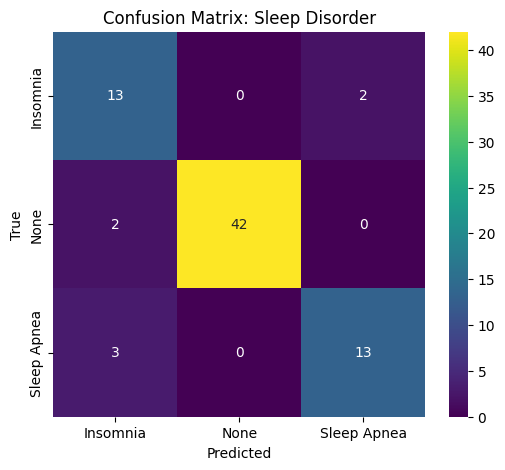

In [34]:
# Prediksi kelas sleep disorder pada data test
y_pred_c = clf_disorder.predict(X_test_c_scaled)

# Hitung akurasi prediksi pada data test
acc = accuracy_score(y_test_c, y_pred_c)
print('Akurasi:', acc)

# Tampilkan classification report (precision, recall, f1-score per kelas)
print(classification_report(y_test_c, y_pred_c, target_names=le_disorder.classes_))

import seaborn as sns

# Hitung confusion matrix untuk evaluasi prediksi per kelas
cm = confusion_matrix(y_test_c, y_pred_c)

# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le_disorder.classes_,
            yticklabels=le_disorder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Sleep Disorder')  # Judul plot
plt.show()


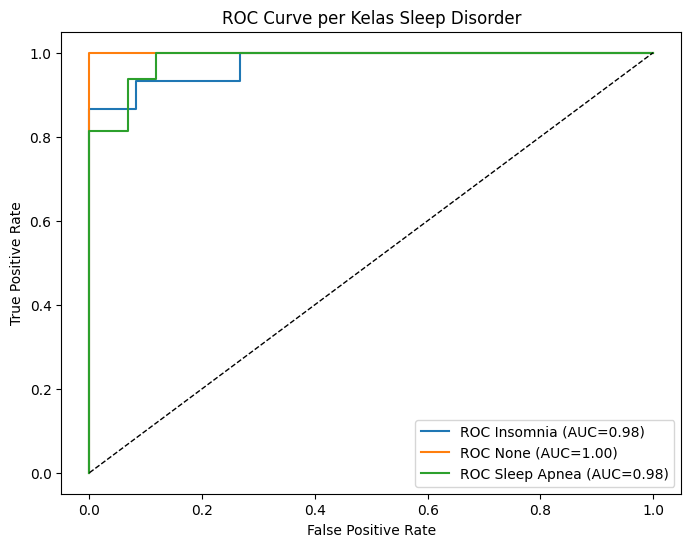

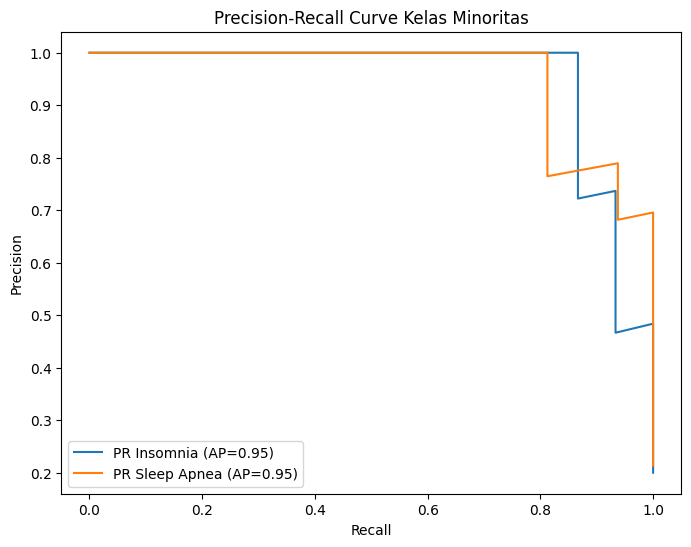

In [35]:
# Dapatkan probabilitas prediksi untuk setiap kelas sleep disorder pada data test
y_pred_c_probs = clf_disorder.predict_proba(X_test_c_scaled)
y_score = y_pred_c_probs  # y_score akan digunakan untuk menghitung ROC dan PR curve

# ROC-AUC (One-vs-Rest) untuk setiap kelas sleep disorder
plt.figure(figsize=(8,6))
for i, class_name in enumerate(le_disorder.classes_):
    # Buat label biner untuk kelas ke-i (1 jika benar kelas tersebut, 0 jika bukan)
    y_true_bin = (y_test_c == i).astype(int)
    # Hitung false positive rate (fpr) dan true positive rate (tpr) untuk kelas ke-i
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, i])
    # Hitung nilai AUC (Area Under Curve) untuk kelas ke-i
    auc = roc_auc_score(y_true_bin, y_score[:, i])
    # Plot ROC curve untuk kelas ke-i
    plt.plot(fpr, tpr, label=f'ROC {class_name} (AUC={auc:.2f})')
# Plot garis diagonal sebagai baseline random
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')  # Label sumbu-x
plt.ylabel('True Positive Rate')   # Label sumbu-y
plt.title('ROC Curve per Kelas Sleep Disorder')  # Judul plot
plt.legend()  # Tampilkan legenda
plt.show()

# Precision-Recall Curve untuk kelas minoritas (Insomnia dan Sleep Apnea)
minority_classes = ['Insomnia', 'Sleep Apnea']  # Daftar kelas minoritas
plt.figure(figsize=(8,6))
for class_name in minority_classes:
    if class_name in le_disorder.classes_:
        # Ambil index kelas minoritas pada label encoder
        idx = list(le_disorder.classes_).index(class_name)
        # Buat label biner untuk kelas minoritas
        y_true_bin = (y_test_c == idx).astype(int)
        # Hitung precision dan recall untuk kelas minoritas
        precision, recall, _ = precision_recall_curve(y_true_bin, y_score[:, idx])
        # Hitung average precision (AP) untuk kelas minoritas
        ap = average_precision_score(y_true_bin, y_score[:, idx])
        # Plot Precision-Recall curve untuk kelas minoritas
        plt.plot(recall, precision, label=f'PR {class_name} (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Kelas Minoritas')
plt.legend() 
plt.show()
